In [1]:
import itertools
import numpy as np 

In [2]:
import sys
sys.path.append('../')
from setupPOMDP import *
from visualizeEnvironment import *
from ValueIteration import *

In [3]:
class SetupEpsilonTransitionWithBarrier(object):
    def __init__(self, stateSet, actionSet):
        self.stateSet = stateSet
        self.actionSet = actionSet

    def __call__(self, barrierList, epsilon=0):
        transitionTable = {state: {action:  self.getStateActionTransition(state, action, epsilon, barrierList) \
                                   for action in self.actionSet}\
                           for state in self.stateSet}
        return(transitionTable) 

    
    def getStateActionTransition(self, currentState, action, epsilon, barriers):
        
        nextState = self.getNextState(currentState, action, barriers)
        
        if currentState == nextState or epsilon == 0:
            transitionDistribution = {nextState: 1}
        else:
            transitionDistribution = {nextState: 1-epsilon, currentState:epsilon}
            
        return(transitionDistribution)

    
    def getNextState(self, state, action, barriers):
        potentialNextState = tuple([state[i] + action[i] for i in range(len(state))])
        
        if potentialNextState in self.stateSet and (not [state, potentialNextState] in barriers):
            return(potentialNextState)
        return(state) 

# Environments

In [4]:
# Actions correspond to E, N, W, S, Stay respectively
allActions = [(1,0), (0,1), (-1,0), (0,-1), (0,0)]

#all location states in grid
gridWidth = 5
gridHeight = 5
gridSet = set(itertools.product(range(gridWidth), range(gridHeight)))

#set of state-next state transitions to remove from each environment
transitionBarriers = [[(2,1),(2,2)],[(2,2), (2,1)], [(3,1), (3,2)], [(3,2), (3,1)],[(4,1), (4,2)], [(4,2), (4,1)]]

#final environment state sets
stateSetC = gridSet

#goal locations
goal1 = (0,4)
goal2 = (4,4)

#probability of ineffective action
epsilon = .1

In [5]:
getTransition = SetupEpsilonTransitionWithBarrier(stateSetC, allActions)

# possible environment transitions
environmentC = getTransition(transitionBarriers, 0)

In [6]:
viewDictionaryStructure(environmentC, levelsTransition)

state: (1, 3)
	action: (1, 0)
		next state: (2, 3)
			probability: 1
	action: (0, 1)
		next state: (1, 4)
			probability: 1
	action: (-1, 0)
		next state: (0, 3)
			probability: 1
	action: (0, -1)
		next state: (1, 2)
			probability: 1
	action: (0, 0)
		next state: (1, 3)
			probability: 1
state: (3, 0)
	action: (1, 0)
		next state: (4, 0)
			probability: 1
	action: (0, 1)
		next state: (3, 1)
			probability: 1
	action: (-1, 0)
		next state: (2, 0)
			probability: 1
	action: (0, -1)
		next state: (3, 0)
			probability: 1
	action: (0, 0)
		next state: (3, 0)
			probability: 1
state: (0, 2)
	action: (1, 0)
		next state: (1, 2)
			probability: 1
	action: (0, 1)
		next state: (0, 3)
			probability: 1
	action: (-1, 0)
		next state: (0, 2)
			probability: 1
	action: (0, -1)
		next state: (0, 1)
			probability: 1
	action: (0, 0)
		next state: (0, 2)
			probability: 1
state: (2, 1)
	action: (1, 0)
		next state: (3, 1)
			probability: 1
	action: (0, 1)
		next state: (2, 1)
			probability: 1
	ac

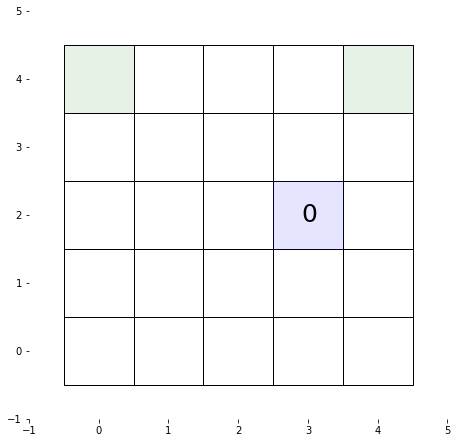

In [7]:
visualizeEnvironment(gridWidth = gridWidth, gridHeight = gridHeight, states = stateSetC, \
                     goalStates = [(0,4, " "), (4,4, " ")], trajectory = [(3,2)])

In [8]:
class SetupRewardTable(object):
    def __init__(self, transitionTable, actionSet, goalState, trapStates):
        self.transitionTable = transitionTable
        self.stateSet = list(transitionTable.keys())
        self.actionSet = actionSet
        self.goalState = goalState
        self.trapStates = trapStates
        
    def __call__(self):
        rewardTable = {state:{action:{nextState: self.applyRewardFunction(state, action, nextState) \
                                      for nextState in nextStateDict.keys() } \
                              for action, nextStateDict in actionDict.items()} \
                       for state, actionDict in self.transitionTable.items()}
        return(rewardTable)

    def applyRewardFunction(self, state, action, nextState):
        goalReward = 10
        trapCost = -100
        moveCost = self.getMoveCost(state, action, nextState)
        
        if state == self.goalState:
            return(goalReward + moveCost)
        elif state in self.trapStates:
            return(trapCost + moveCost)
        return(moveCost)
    
    def getMoveCost(self, state, action, nextState):
        if action == (0,0):
            return(-.1)
        else:
            actionDistance = sum([abs(action[i]) for i in range(len(action))])
            return(-actionDistance)

In [9]:
getRewardC = SetupRewardTable(environmentC, allActions, goal2, [])
reward = getRewardC()

In [10]:
reward

{(1, 3): {(1, 0): {(2, 3): -1},
  (0, 1): {(1, 4): -1},
  (-1, 0): {(0, 3): -1},
  (0, -1): {(1, 2): -1},
  (0, 0): {(1, 3): -0.1}},
 (3, 0): {(1, 0): {(4, 0): -1},
  (0, 1): {(3, 1): -1},
  (-1, 0): {(2, 0): -1},
  (0, -1): {(3, 0): -1},
  (0, 0): {(3, 0): -0.1}},
 (0, 2): {(1, 0): {(1, 2): -1},
  (0, 1): {(0, 3): -1},
  (-1, 0): {(0, 2): -1},
  (0, -1): {(0, 1): -1},
  (0, 0): {(0, 2): -0.1}},
 (2, 1): {(1, 0): {(3, 1): -1},
  (0, 1): {(2, 1): -1},
  (-1, 0): {(1, 1): -1},
  (0, -1): {(2, 0): -1},
  (0, 0): {(2, 1): -0.1}},
 (0, 3): {(1, 0): {(1, 3): -1},
  (0, 1): {(0, 4): -1},
  (-1, 0): {(0, 3): -1},
  (0, -1): {(0, 2): -1},
  (0, 0): {(0, 3): -0.1}},
 (4, 0): {(1, 0): {(4, 0): -1},
  (0, 1): {(4, 1): -1},
  (-1, 0): {(3, 0): -1},
  (0, -1): {(4, 0): -1},
  (0, 0): {(4, 0): -0.1}},
 (1, 2): {(1, 0): {(2, 2): -1},
  (0, 1): {(1, 3): -1},
  (-1, 0): {(0, 2): -1},
  (0, -1): {(1, 1): -1},
  (0, 0): {(1, 2): -0.1}},
 (3, 3): {(1, 0): {(4, 3): -1},
  (0, 1): {(3, 4): -1},
  (-1, 0): {(

In [11]:
valueTable = {state:0 for state in reward.keys()}

getPolicyA = BoltzmannValueIteration(environmentC, reward, valueTable, 10e-7, .99, .2)
optimalValuesA, policyA = getPolicyA()

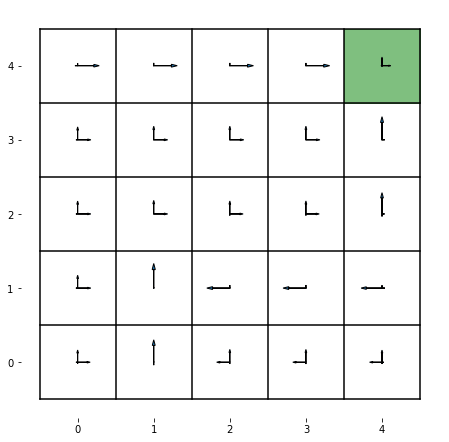

In [12]:
visualizePolicy(5, 5, goal2, [], [], policyA)